# **Importação e Visualização dos Dados**

In [1]:
# !pip install --upgrade huggingface_hub
# !pip install datasets

In [11]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import io

FIG_NUMBER = 1
IMG_HEIGHT = 1024
IMG_WIDTH = 768

In [3]:
%%time
dataset = load_dataset("pierreguillou/DocLayNet-base", trust_remote_code=True)
# dataset = load_dataset("pierreguillou/DocLayNet-small", trust_remote_code=True)

CPU times: total: 2.38 s
Wall time: 6.49 s


In [4]:
df_train = dataset['train'].to_pandas()
df_validation = dataset['validation'].to_pandas()
df_test = dataset['test'].to_pandas()

## **Distribuição dos Dados**

In [5]:
doc_categories = df_train.doc_category.unique()
num_classes = len(doc_categories)

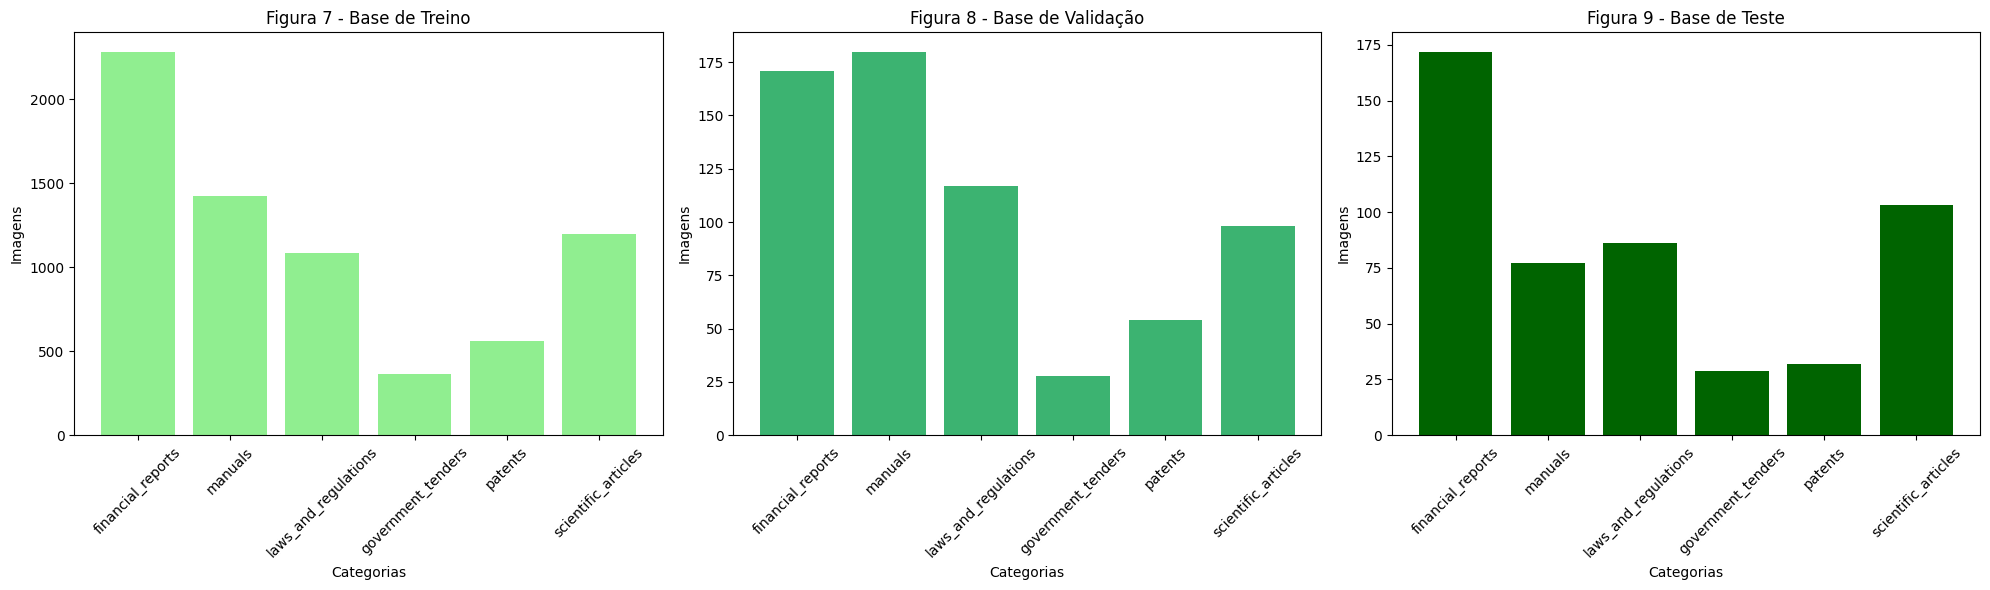

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

def plot_image_distribution(dataframe, axis, base_name, color):
    global FIG_NUMBER
    num_images = []
    for i in range(num_classes):
        class_data = dataframe[dataframe['doc_category'] == doc_categories[i]]
        count = class_data.shape[0]
        num_images.append(count)

    axs[axis].bar(doc_categories, num_images, color=f'{color}')
    axs[axis].set_xticks(range(len(doc_categories)))
    axs[axis].set_xticklabels(doc_categories, rotation=45)
    axs[axis].set_title(f'Figura {FIG_NUMBER} - Base de {base_name}')
    axs[axis].set_xlabel('Categorias')
    axs[axis].set_ylabel('Imagens')
    FIG_NUMBER += 1

plot_image_distribution(df_train, 0, 'Treino', 'lightgreen')
plot_image_distribution(df_validation, 1, 'Validação', 'mediumseagreen')
plot_image_distribution(df_test, 2, 'Teste', 'darkgreen')

plt.tight_layout()
plt.show()

In [9]:
class_data = df_train[df_train['doc_category'] == 'manuals']
print(class_data.shape[0])

class_data = df_validation[df_validation['doc_category'] == 'manuals']
print(class_data.shape[0])

class_data = df_test[df_test['doc_category'] == 'manuals']
print(class_data.shape[0])

1422
180
77


> - A distribuição das categorias de imagens é relativamente semelhante entre as bases, a categoria com mais disparidade é ***manuals***, sendo:  
> **1422** para a base de **treino**  
> **180** para a base de **validação**  
> **77** para a base de **teste**  

## **Pré Processamento da Imagem**

In [ ]:
print(df_train['image'][0]['bytes'])
# array = np.array(df_train['image'][0]['bytes'])
# array = np.frombuffer(df_train['image'][0]['bytes'])
# array

In [29]:
def get_png_array(df_row):
    png_bytes = df_row['bytes']

    # Converta os bytes da imagem em um objeto Image
    image = Image.open(io.BytesIO(png_bytes))
    
    grayscale_image = image.convert('L')
    
    # Redimensione a imagem
    resized_image = grayscale_image.resize((IMG_WIDTH, IMG_HEIGHT))

    # Converta a imagem redimensionada para um array NumPy
    image_array = np.array(resized_image)
    
    return image_array

In [30]:
df_train['image_array'] = df_train['image'].apply(lambda x: get_png_array(x))

In [35]:
df_train['image_array'][0].shape

(1024, 768)

In [51]:
df_validation['image_array'] = df_validation['image'].apply(lambda x: get_png_array(x))

## **Implementação da Rede Neural Artificial**

In [ ]:
# x_train = df_train['image_array']
# y_train = df_train['doc_category']
%%time

x_train = np.stack(df_train['image_array'].values)
x_val = np.stack(df_validation['image_array'].values)

MemoryError: Unable to allocate 5.06 GiB for an array with shape (6910, 1024, 768) and data type uint8

UsageError: Line magic function `%%time` not found.
KeyboardInterrupt



In [37]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()
# Aplicando one-hot encoding nas labels da base de treino
y_train_encoded = label_binarizer.fit_transform(y_train)

In [52]:
x_val = df_validation['image_array']

y_val = df_validation['doc_category']

In [53]:
y_val_encoded = label_binarizer.fit_transform(y_val)

### **Rede Neural Artificial Densa**

In [46]:
# Importando bibliotecas para criação e treinamento dos modelos
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay

In [50]:
neural_network_modelv2 = Sequential([
    Flatten(input_shape=(IMG_HEIGHT*IMG_WIDTH,)),
    Dropout(0.2),
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

adam = Adam(learning_rate=0.001)
neural_network_modelv2.compile(optimizer=adam,
              loss=["categorical_crossentropy"],
              metrics=['accuracy'])

neural_network_modelv2.summary()

c:\Users\018117631\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 786432)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 786432)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │   157,286,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,312,260 (600.10 MB)

 Trainable params: 157,312,260 (600.10 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
callback = EarlyStopping(monitor='loss', patience=5)
neural_network_historyv2 = neural_network_modelv2.fit(np.array(x_train),
          np.array(y_train_encoded),
          epochs=100,
          batch_size=500,
          verbose=0,
          shuffle=True,
          validation_data=(np.array(x_val), np.array(y_val_encoded)),
          callbacks=[callback])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,8))
axs[1, 0].plot(neural_network_historyv2.history['accuracy'], color='violet', label='accuracy')
axs[1, 0].plot(neural_network_historyv2.history['val_accuracy'], color='darkviolet', label='val_accuracy')
axs[1, 0].set_title('Acurácia Rede Neural v2', fontsize=10)

axs[1, 1].plot(neural_network_historyv2.history['loss'], color='orange',label='loss')
axs[1, 1].plot(neural_network_historyv2.history['val_loss'], color='tomato', label='val_loss')
axs[1, 1].set_title('Perda Rede Neural v2', fontsize=10)

axs[1, 0].legend(loc="upper left")
axs[1, 1].legend(loc="upper left")
plt.tight_layout()
plt.show()